# Instacart market basket_analysis

    The goal of a data scientist is to derive value from such unstructured data.  In this project, we use analyze over 3 million user grocery shopping orders from more than 200,000 anonymized Instacart users. The dataset used was sourced from Instacart's first public dataset release, “The Instacart Online Grocery Shopping Dataset 2017”, and acquired from Kaggle. Here we attempt to identify key patterns and granular details from this data that would be of use when making business and marketing decision. 

# Setup
## Downloading Packages

In [2]:
# To install the kaggle package in the notebook WARNING Installs System wide
# Download API key from Kaggle from Accounts - Create New Api Token
# Move the downloaded kaggle.json to ~/.kaggle/

# import sys
# !{sys.executable} -m pip install kaggle

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-darkgrid')
color = sns.color_palette()
%matplotlib inline

## Downloading Instacart data using the Kaggle API
Unzipping and Cleaning CSV zip files

In [2]:
# Downloading CSV data, unzipping and moving to csv_src folder

# After isntalling the kaggle module and setting kaggle.json api keys
# Download the dataset from the Kaggle
!kaggle competitions download -c instacart-market-basket-analysis

# Custom shell script to unzip all files, remove zips and move csv into csv_src
# The unzip_rm.sh script should be in the same directory as the python notebook file
!chmod u+x unzip_rm.sh
!./unzip_rm.sh

  0%|                                                 | 0.00/804 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 804/804 [00:00<00:00, 362kB/s]
  0%|                                               | 0.00/1.87k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.87k/1.87k [00:00<00:00, 578kB/s]
100%|██████████████████████████████████████| 6.90M/6.90M [00:00<00:00, 8.03MB/s]

100%|████████████████████████████████████████| 795k/795k [00:00<00:00, 7.88MB/s]

 99%|█████████████████████████████████████▋| 31.0M/31.3M [00:04<00:00, 8.21MB/s]
100%|██████████████████████████████████████| 31.3M/31.3M [00:04<00:00, 7.69MB/s]
100%|███████████████████████████████████████▉| 157M/157M [00:21<00:00, 8.23MB/s]
100%|████████████████████████████████████████| 157M/157M [00:21<00:00, 7.78MB/s]
  0%|                                                | 0.00/220k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 220k/220k [00:00<00:00, 10.5MB/s]
Archive:  aisles.csv.zip
 

## Loading CSV files into DataFrames

In [3]:
# Reading all the datasets from the csv_src folder
csv_folder = 'csv_src/'
aisle = pd.read_csv( csv_folder+'aisles.csv')
orders = pd.read_csv(csv_folder+'orders.csv')
products = pd.read_csv(csv_folder+'products.csv')
departments = pd.read_csv( csv_folder+'departments.csv')
order_prior = pd.read_csv(csv_folder+'order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'order_products__train.csv')

## Setting the ids as index
#### Setting NAs to zeros

In [4]:
# Setting the correct indexes for the data sets

orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

## Taking a look at all available data

In [5]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [6]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [7]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [8]:
aisle.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [9]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:
print(aisle.shape, products.shape, departments.shape, order_train.shape, order_prior.shape, orders.shape)

(134, 1) (49688, 3) (21, 1) (1384617, 4) (32434489, 4) (3421083, 6)


## Joining the products dframe with departments and aisle dframes

In [12]:
# Doing inner joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")

In [13]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [14]:
product_comb.head()

,aisle_id,department_id,product_name,department,aisle
product_id,,,,,
1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,104,13,All-Seasons Salt,pantry,spices seasonings
3,94,7,Robust Golden Unsweetened Oolong Tea,beverages,tea
4,38,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
5,5,13,Green Chile Anytime Sauce,pantry,marinades meat preparation


## Functions to generate seaborn hist count and matplotlib bar plots

In [23]:
def hist_count_plots(dframe, x_axis, _title, _xlabel, _ylabel, color_index, fig_size=(15,8), title_size=18):
   
    plt.figure(figsize=fig_size)
    sns.countplot(x=x_axis, data=dframe, color=color[color_index])
    plt.title(_title, fontsize=title_size)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    
    if x_axis == "order_dow":
        plt.xticks( [0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"] )
    plt.show()   

def bar_plot(dframe, _xlabel, _ylabel, _title, fig_size=(18,8), title_size=18):
    dframe.plot(kind='bar', figsize=fig_size)
    plt.xlabel(_xlabel, fontsize=14)
    plt.ylabel(_ylabel, fontsize=14)
    plt.title(_title, fontsize=title_size)

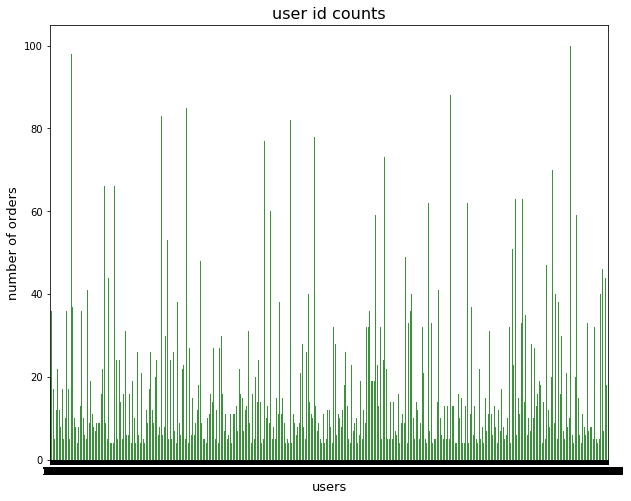

In [27]:
hist_count_plots(orders.iloc[:1000000,:], 'user_id', 'user id counts', "users", "number of orders", 2)

## Generating a dframe with total order counts for each user

In [33]:
user_order_count_df = orders.groupby('user_id').user_id.count()
user_order_count_df.describe()
user_order_count_df = user_order_count_df.to_frame()
user_order_count_df = user_order_count_df.rename(columns={'user_id': 'Order_count'})
user_order_count_df.head()

,Order_count
user_id,
1,11
2,15
3,13
4,6
5,5


## Descriptive Statistics on the number of orders by each user

In [34]:
user_order_count_df.describe()

,Order_count
count,206209.000000
mean,16.590367
std,16.654774
min,4.000000
25%,6.000000
50%,10.000000
75%,20.000000
max,100.000000


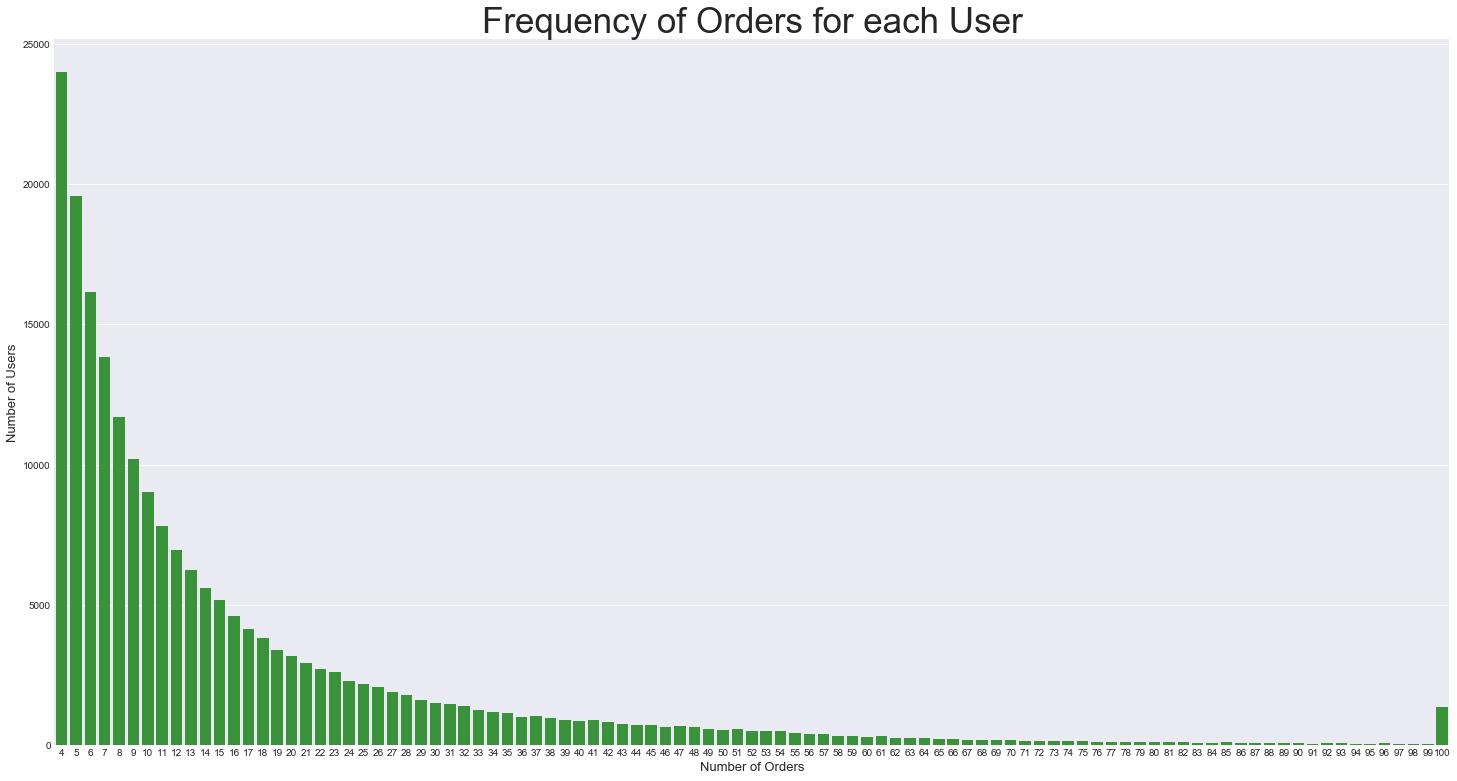

In [29]:
hist_count_plots(user_order_count_df ,"Order_count", "Frequency of Orders for each User",
                 "Number of Orders", "Number of Users", 2, fig_size=(25,13), title_size=35 )

## Looking at Order Frequency by the hour of the day

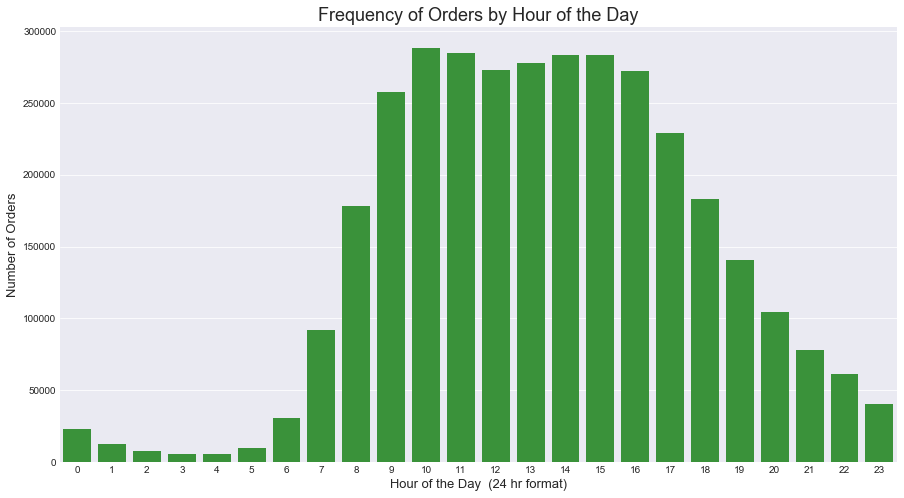

In [30]:
hist_count_plots(orders ,"order_hour_of_day", "Frequency of Orders by Hour of the Day",
                 "Hour of the Day  (24 hr format)", "Number of Orders", 2)

## Looking at Order Frequency by the days of the Week

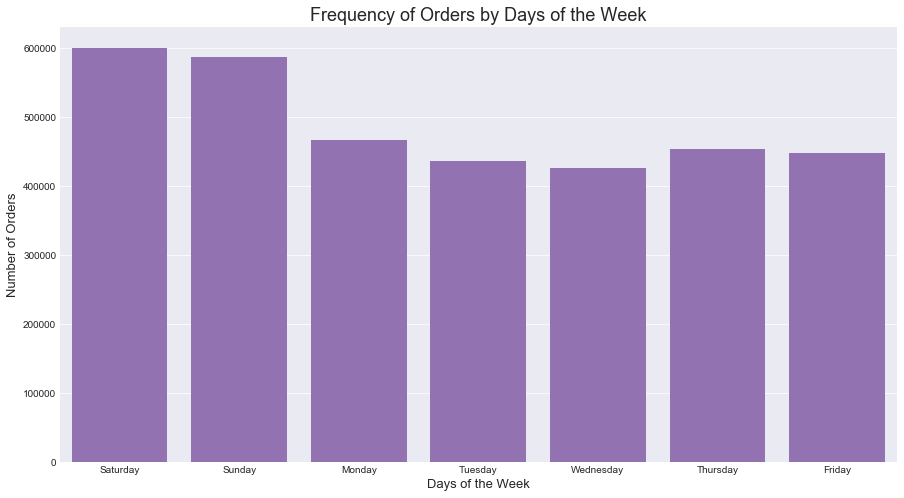

In [31]:
hist_count_plots(orders, "order_dow", "Frequency of Orders by Days of the Week",
                 "Days of the Week", "Number of Orders", 4)

## Continuous bivariate density of orders between day of the week and hour of the day

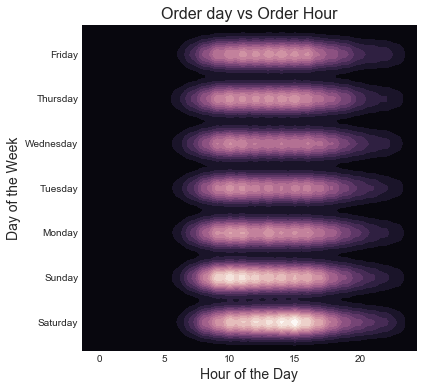

In [123]:
# using a small sample for kernel density axes 
smallset = orders[0:100000]

f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(smallset.order_hour_of_day, smallset.order_dow, cmap=cmap, n_levels=15, shade=True);
plt.title("Order day vs Order Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Day of the Week", fontsize=14)
plt.yticks([0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
plt.show()

## Alternate Continuous bivariate density of orders between day of the week and hour of the day

Order day vs Order Hour


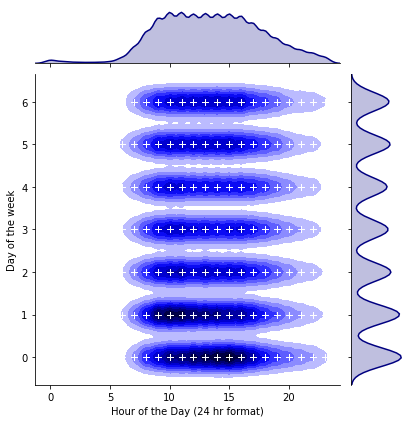

In [258]:
print("Order day vs Order Hour")
kde2 = sns.jointplot(x="order_hour_of_day", y="order_dow", data=smallset, kind="kde", color="navy")
kde2.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
kde2.ax_joint.collections[0].set_alpha(0)
kde2.set_axis_labels("Hour of the Day (24 hr format)", "Day of the week")

## Frequency Distribution by days since prior order

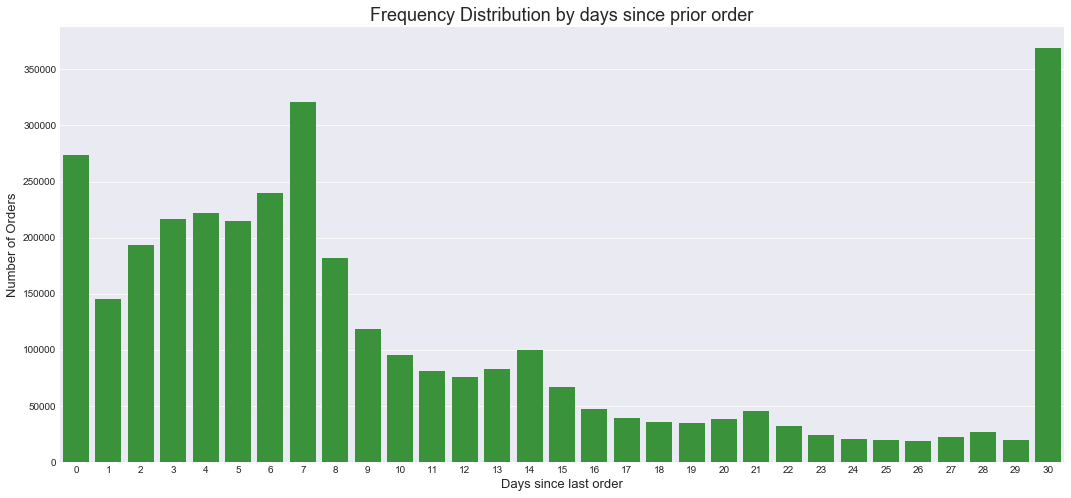

In [321]:
# Generating a dataframe with one column 'days_since_prior_order'
prior_order = orders[['days_since_prior_order']].astype(np.int64) 
hist_count_plots(prior_order, "days_since_prior_order", "Frequency Distribution by days since prior order",
                 "Days since last order", "Number of Orders", 2)

## Alternate view of Frequency Density cross between days since prior order and the day of the week

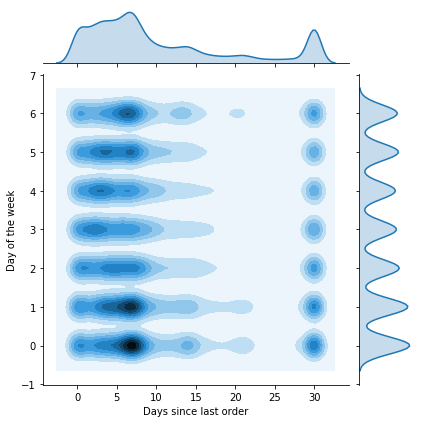

In [259]:
kde3 = sns.jointplot(smallset.days_since_prior_order, smallset.order_dow, data=smallset, kind="kde")
kde3.set_axis_labels("Days since last order", "Day of the week")

## Combining our product_comb and order_prior data frames

In [35]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_prior = order_prior.set_index('product_id').join(product_comb, how="inner")

In [36]:
product_prior.head()

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


## Grouping all the product orders by their departments
And Generating a Order Frequency by Department bar chart

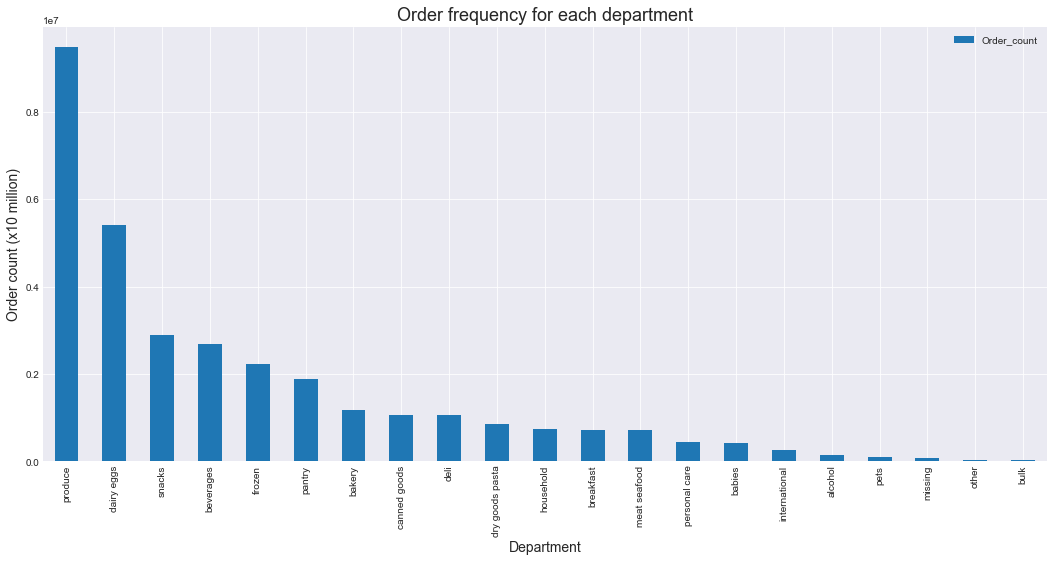

In [128]:
department_count_df = product_prior.groupby('department').department.count()
department_count_df = department_count_df.to_frame()
department_count_df = department_count_df.rename(columns={'department': 'Order_count'})
department_count_df.sort_values(by='Order_count', ascending=False, inplace=True)
bar_plot(department_count_df, "Department", "Order count (x10 million)", "Order frequency for each department")

In [129]:
# Generating a percentage column for the order counts for each department
department_count_df['% of total orders'] = (
    department_count_df.Order_count / department_count_df.Order_count.sum())*100

## Pie Chart showing top ten department breakdown

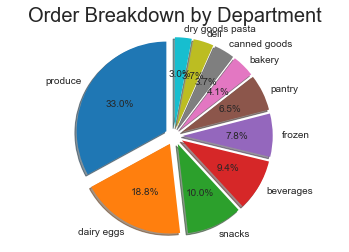

In [130]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = department_count_df.index[:10]
sizes = department_count_df.iloc[:10,1]
explode = [ 0.1 for i in range(10) ] #(department_count_df.shape[0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Order Breakdown by Department", fontsize=20)

plt.show()

## Grouping all the products by the number of times they were ordered

In [39]:
product_count_df = product_prior.groupby('product_name').product_name.count()
product_count_df = product_count_df.to_frame()
product_count_df = product_count_df.rename(columns={'product_name': 'Order_count'})

In [40]:
product_count_df.describe()

,Order_count
count,49677.000000
mean,652.907563
std,4792.114416
min,1.000000
25%,17.000000
50%,60.000000
75%,260.000000
max,472565.000000


In [49]:
# sort the product_count_df dataframe by Order_count in a descending manner
desc_product_count_df = product_count_df.sort_values(by=['Order_count'], ascending=False)

## Top ten most ordered products

In [85]:
desc_product_count_df.head(10)

,Order_count
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
Organic Avocado,176815
Large Lemon,152657
Strawberries,142951
Limes,140627
